In [1]:
import math
import os
import pickle
from functools import partial

import matplotlib.cm as cm
import numpy as np
import pandas as pd
import pyabc
import scipy.stats as stats
import seaborn as sns
from fitmulticell import model as morpheus_model
from fitmulticell.sumstat import SummaryStatistics

from summary_stats import reduced_coordinates_to_sumstat, reduce_to_coordinates, compute_mean_summary_stats, cut_region

# get the job array id and number of processors
job_array_id = int(os.environ.get('SLURM_ARRAY_TASK_ID', 0))
n_procs = int(os.environ.get('SLURM_CPUS_PER_TASK', 1))
print(job_array_id)
on_cluster = False

0


In [2]:
if on_cluster:
    gp = '/home/jarruda_hpc/CellMigration/synth_data_params_bayesflow'
else:
    gp = os.getcwd()

# defining the mapping of parameter inside the model xml file. the dictionary name is for 
# parameter name, and the value are the mapping values, to get the map value for parameter 
# check here: https://fitmulticell.readthedocs.io/en/latest/example/minimal.html#Inference-problem-definition

par_map = {
    'gradient_strength': './CellTypes/CellType/Constant[@symbol="gradient_strength"]',
    'move.strength': './CellTypes/CellType/Constant[@symbol="move.strength"]',  # 0.21359842373064927*0.01
    #'move.duration.mean': './CellTypes/CellType/Constant[@symbol="move.duration.mean"]',
    #'move.duration.median': './CellTypes/CellType/Constant[@symbol="move.duration.median"]',
    'move.duration.scale': './CellTypes/CellType/Constant[@symbol="move.duration.scale"]',
    'cell_nodes': './Global/Constant[@symbol="cell_nodes"]',
}

model_path = gp + "/cell_movement_v23.xml"  # time step is 30sec, move.dir completely normalized, init move.dir rand in all directions
# defining the summary statistics function
max_sequence_length = 120
min_sequence_length = 0
only_longest_traj_per_cell = True  # mainly to keep the data batchable
sumstat = SummaryStatistics(sum_stat_calculator=partial(reduce_to_coordinates,
                                                        minimal_length=min_sequence_length,
                                                        maximal_length=max_sequence_length,
                                                        only_longest_traj_per_cell=only_longest_traj_per_cell))                    

if on_cluster:
    # define the model object
    model = morpheus_model.MorpheusModel(
        model_path, par_map=par_map, par_scale="lin",
        show_stdout=False, show_stderr=False,
        executable="ulimit -s unlimited; /home/jarruda_hpc/CellMigration/morpheus-2.3.7",
        clean_simulation=True,
        raise_on_error=False, sumstat=sumstat)

    # todo: remember also change tiff path in model.xml!
else:
    # define the model object
    model = morpheus_model.MorpheusModel(
        model_path, par_map=par_map, par_scale="lin",
        show_stdout=False, show_stderr=False,
        clean_simulation=True,
        raise_on_error=False, sumstat=sumstat)


# parameter values used to generate the synthetic data
obs_pars = {
    'gradient_strength': 500000.,  # strength of the gradient of chemotaxis
    'move.strength': 1.,  # strength of directed motion
    #'move.duration.mean': 100,  # mean waiting time of exponential distribution
    #'move.duration.median': 972.33,  # median waiting time of gamma distribution (actually the mean)
    # rand_gamma(move.duration.median/move.duration.scale,move.duration.scale)
    'move.duration.scale': 30.,  # median of exponential distribution
    'cell_nodes': 30.,  # volume of the cell
    #'d_env': 0.01,  # influence of random motion vs biased direction (previous movement?)
    # d_env * move.dir.x / move.dir.abs + (1-d_env)*cos(alpha), d_env * move.dir.y / move.dir.abs + (1-d_env)*sin(alpha) , 0
}

# define the parameter scale
model.par_scale = "log10"
# define parameters' limits
obs_pars_log = {key: math.log10(val) for key, val in obs_pars.items()}
#limits_old = {key: (math.log10((10 ** -3) * val), math.log10((10 ** 3) * val)) for
#          key, val in obs_pars.items()}
limits = {'gradient_strength': (math.log10(10 ** 4), math.log10(10 ** 12)), 
          'move.strength': (0, math.log10(10 ** 5)),
          'move.duration.scale': (math.log10((10 ** -2) * 30), math.log10((10 ** 2) * 30)),
          'cell_nodes': (math.log10(10 ** 0), math.log10(10 ** 2))}

# restrict waiting time with respect to duration scale of gamma distribution, only this prior changed
#limits['move.duration.median'] = (limits['move.duration.median'][0], np.log10(96899.44860996476)) 
#limits['d_env'] = (math.log10(10 ** -5), math.log10(10 ** 0))
#limits_old['cell_nodes'] = (math.log10(10 ** 0), math.log10(10 ** 2))

prior = pyabc.Distribution(**{key: pyabc.RV("uniform", lb, ub - lb)
                              for key, (lb, ub) in limits.items()})
param_names = list(obs_pars.keys())
print(obs_pars)

{'gradient_strength': 500000.0, 'move.strength': 1.0, 'move.duration.scale': 30.0, 'cell_nodes': 30.0}


In [3]:
import tensorflow as tf
import bayesflow as bf
from bayesflow.amortizers import AmortizedPosterior
from bayesflow.networks import InvertibleNetwork
from bayesflow.helper_networks import MultiConv1D
from bayesflow.simulation import GenerativeModel, Prior, Simulator
from bayesflow.trainers import Trainer
from bayesflow import default_settings as defaults
from bayesflow.computational_utilities import maximum_mean_discrepancy
from tensorflow.keras.layers import Dense, GRU, LSTM, Bidirectional
from tensorflow.keras.models import Sequential


def prior_fun(batch_size: int) -> np.ndarray:
    samples = []
    for _ in range(batch_size):
        samples.append(list(prior.rvs().values()))
    return np.array(samples)


def generate_population_data(param_batch: np.ndarray, cells_in_population: int, max_length: int) -> np.ndarray:
    """
    Generate population data
    :param param_batch:  batch of parameters
    :param cells_in_population:  number of cells in a population (50)
    :param max_length:  maximum length of the sequence
    :return:
    """
    data_batch = []
    for params in param_batch:
        params_dict = {key: p for key, p in zip(obs_pars.keys(), params)}
        sim = model.sample(params_dict)
        data_batch.append(sim)  # generates a cell population in one experiment

    data_batch_transformed = np.ones((param_batch.shape[0], cells_in_population, max_length, 2)) * np.nan
    # each cell is of different length, each with x and y coordinates, make a tensor out of it
    n_cells_not_visible = 0
    for p_id, population_sim in enumerate(data_batch):
        if len(population_sim) == 0:
            # no cells were visible in the simulation
            n_cells_not_visible += 1
            continue
        for c_id, cell_sim in enumerate(population_sim):
            # pre-pad the data with zeros, but first write zeros as nans to compute the mean and std
            data_batch_transformed[p_id, c_id, -len(cell_sim['x']):, 0] = cell_sim['x']
            data_batch_transformed[p_id, c_id, -len(cell_sim['y']):, 1] = cell_sim['y']

    if n_cells_not_visible > 0:
        print(f'Simulation with no cells visible: {n_cells_not_visible}/{len(data_batch)}')
    return data_batch_transformed

/Users/jonas.arruda/miniconda/envs/CellMigration/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
presimulate = False
presimulation_path = 'presimulations'
n_val_data = 100
cells_in_population = 50
n_params = len(obs_pars)
batch_size = 32
iterations_per_epoch = 100
# 4000 batches to be generated, 40 epochs until the batch is used again
epochs = 500

# check if gpu is available
print('gpu:', tf.config.list_physical_devices('GPU'))

bayesflow_prior = Prior(batch_prior_fun=prior_fun, param_names=param_names)
bayes_simulator = Simulator(batch_simulator_fun=partial(generate_population_data,
                                                        cells_in_population=cells_in_population,
                                                        max_length=max_sequence_length))
generative_model = GenerativeModel(prior=bayesflow_prior, simulator=bayes_simulator,
                                   skip_test=True,  # once is enough, simulation takes time
                                   name="Normalizing Flow Generative Model")

gpu: []


In [5]:
if presimulate:
    print('presimulating')
    from time import sleep
    sleep(job_array_id)
    
    # we create on batch per job and save it in a folder
    epoch_id = job_array_id // iterations_per_epoch
    generative_model.presimulate_and_save(batch_size=batch_size, 
                                          folder_path=presimulation_path+f'/epoch_{epoch_id}',
                                          iterations_per_epoch=1,
                                          epochs=1,
                                          extend_from=job_array_id,
                                          disable_user_input=True)
    print('Done!')

In [6]:
def custom_loader(file_path):
    """Uses pickle to load, but each path is folder with multiple files, each one batch"""
    # load all files in folder
    loaded_presimulations = []
    for file in os.listdir(file_path):
        with open(os.path.join(file_path, file), 'rb') as f:
            test = pickle.load(f)[0]
            assert isinstance(test, dict)
            loaded_presimulations.append(test)
    # shuffle list, so iterations are random, only batches stay the same
    np.random.shuffle(loaded_presimulations)
    return loaded_presimulations

In [7]:
if os.path.exists(os.path.join(gp, 'validation_data.pickle')):
    with open(os.path.join(gp, 'validation_data.pickle'), 'rb') as f:
        valid_data = pickle.load(f)
else:
    print('Generating validation data')
    valid_data = generative_model(n_val_data)
    # save the data
    with open(os.path.join(gp, 'validation_data.pickle'), 'wb') as f:
        pickle.dump(valid_data, f)

x_mean = np.nanmean(valid_data['sim_data'], axis=(0, 1, 2))
x_std = np.nanstd(valid_data['sim_data'], axis=(0, 1, 2))
p_mean = np.mean(valid_data['prior_draws'], axis=0)
p_std = np.std(valid_data['prior_draws'], axis=0)
print('Mean and std of data:', x_mean, x_std)
print('Mean and std of parameters:', p_mean, p_std)


# compute the mean of the summary statistics
summary_stats_list_ = [reduced_coordinates_to_sumstat(t) for t in valid_data['sim_data']]
(_, _, _, _, _, ad_averg, MSD_averg, 
 TA_averg, VEL_averg, WT_averg) = compute_mean_summary_stats(summary_stats_list_, remove_nan=False)
direct_conditions_ = np.stack([ad_averg, MSD_averg, TA_averg, VEL_averg, WT_averg]).T
# replace inf with -1
direct_conditions_[np.isinf(direct_conditions_)] = np.nan
        
summary_valid_max = np.nanmax(direct_conditions_, axis=0)
summary_valid_min = np.nanmin(direct_conditions_, axis=0)

Mean and std of data: [ 585.89033567 1227.68195789] [110.06691401  56.97566162]
Mean and std of parameters: [7.7255934  2.53043535 1.33883171 0.9615413 ] [2.29744498 1.38458939 1.193231   0.60666121]


/Users/jonas.arruda/miniconda/envs/CellMigration/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jonas.arruda/miniconda/envs/CellMigration/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [8]:
def configurator(forward_dict: dict, remove_nans: bool = False, manual_summary: bool = False) -> dict:
    out_dict = {}

    # Extract data
    x = forward_dict["sim_data"]
    
    if remove_nans:
        # check if simulation with only nan values in a row
        non_nan_populations = np.isnan(x).sum(axis=(1,2,3))-np.prod(x.shape[1:]) != 0
        #print(x.shape[0]-non_nan_populations.sum(), 'samples with only nan values in a row')
        x = x[non_nan_populations]
    
    # compute manual summary statistics
    if manual_summary:
        summary_stats_list = [reduced_coordinates_to_sumstat(t) for t in x]
        # compute the mean of the summary statistics
        (_, _, _, _, _, 
         ad_averg, MSD_averg, 
         TA_averg, VEL_averg, WT_averg) = compute_mean_summary_stats(summary_stats_list, remove_nan=False)
        direct_conditions = np.stack([ad_averg, MSD_averg, TA_averg, VEL_averg, WT_averg]).T   
        # normalize statistics
        direct_conditions = (direct_conditions - summary_valid_min) / (summary_valid_max - summary_valid_min)
        # replace nan or inf with -1
        direct_conditions[np.isinf(direct_conditions)] = -1
        direct_conditions[np.isnan(direct_conditions)] = -1
        out_dict['direct_conditions'] = direct_conditions.astype(np.float32)
    
    # Normalize data
    x = (x - x_mean) / x_std
    
    # Check for NaN values in the first entry of the last axis
    # If nan_mask is False (no NaNs), set to 1; otherwise, set to 0
    nan_mask = np.isnan(x[..., 0])
    new_dim = np.where(nan_mask, 0, 1)
    new_dim_expanded = np.expand_dims(new_dim, axis=-1)
    x = np.concatenate((x, new_dim_expanded), axis=-1)

    # Normalize data
    x[np.isnan(x)] = 0  # replace nan with 0, pre-padding (since we have nans in the data at the end)
    out_dict['summary_conditions'] = x.astype(np.float32)

    # Extract params
    if 'parameters' in forward_dict.keys():
        forward_dict["prior_draws"] = forward_dict["parameters"]
    if 'prior_draws' in forward_dict.keys():
        params = forward_dict["prior_draws"]
        if remove_nans:
            params = params[non_nan_populations]
        params = (params - p_mean) / p_std
        out_dict['parameters'] = params.astype(np.float32)
    return out_dict

In [9]:
# define the network
class GroupSummaryNetwork(tf.keras.Model):
    """Network to summarize the data of groups of cells.  Each group is passed through a series of convolutional layers
    followed by an LSTM layer. The output of the LSTM layer is then pooled across the groups and dense layer applied
    to obtain a summary of fixed dimensionality. The network is invariant to the order of the groups.
    """
    def __init__(
            self, 
            summary_dim, 
            num_conv_layers=2, 
            rnn_units=128, 
            use_lstm=True, 
            bidirectional=False,
            conv_settings=None, 
            use_attention=False,
            **kwargs
    ):
        super().__init__(**kwargs)
        
        if conv_settings is None:
            conv_settings = defaults.DEFAULT_SETTING_MULTI_CONV

        self.conv = Sequential([MultiConv1D(conv_settings) for _ in range(num_conv_layers)])
        self.use_attention = use_attention
        
        if use_lstm:
            self.rnn = Bidirectional(LSTM(rnn_units, return_sequences=use_attention)) if bidirectional else LSTM(rnn_units, return_sequences=use_attention)
        else:
            self.rnn = GRU(LSTM(rnn_units, return_sequences=use_attention)) if bidirectional else LSTM(rnn_units, return_sequences=use_attention)

        if self.use_attention:
            self.attention = tf.keras.layers.Attention()
        self.out_layer = Dense(summary_dim, activation="linear")
        self.summary_dim = summary_dim

    def call(self, x, **kwargs):
        """Performs a forward pass through the network by first passing `x` through the same rnn network for
        each household and then pooling the outputs across households.

        Parameters
        ----------
        x : tf.Tensor
            Input of shape (batch_size, n_groups, n_time_steps, n_features)

        Returns
        -------
        out : tf.Tensor
            Output of shape (batch_size, summary_dim)
        """
        # iterate over groups
        out_list = []  # list to store outputs of LSTM for each group
        for g_i in range(x.shape[1]):
            out = self.conv(x[:, g_i], **kwargs)  # (batch_size, n_time_steps, n_filters) -> default: filters=32
            out = self.rnn(out, **kwargs)  # (batch_size, lstm_units) 
            # if attention is used, return full sequence (batch_size, n_time_steps, lstm_units)
            # bidirectional LSTM returns 2*lstm_units
            out_list.append(out)
        if self.use_attention:
            # learn a query vector to attend over the groups, some groups might be more important
            # this should be invariant to the order of the groups (depends on the learned attention mechanism)
            out = tf.stack(out_list, axis=1)  # (batch_size, n_groups, n_time_steps, lstm_units)
            query = tf.reduce_mean(out, axis=2)  # (batch_size, n_groups, lstm_units)
            # Reshape query to match the required shape for attention
            query = tf.expand_dims(query, axis=2)  # (batch_size, n_groups, 1, lstm_units)
            out = self.attention([query, out], **kwargs)  # (batch_size, n_groups, 1, lstm_units)
            out = tf.reduce_max(out, axis=1)  # (batch_size, 1, lstm_units)
            out = tf.squeeze(out, axis=1)  # Remove the extra dimension (batch_size, lstm_units)
        else:
            # max pooling over groups, this totally invariants to the order of the groups
            out = tf.reduce_max(out_list, axis=0)  # (batch_size, lstm_units)
        # apply dense layer
        out = self.out_layer(out, **kwargs)  # (batch_size, summary_dim)
        return out

job_array_id = 6

num_coupling_layers = 6
num_dense = 3
use_attention = False
use_bidirectional = False
summary_loss = None
use_manual_summary = False
if job_array_id == 0:
    checkpoint_path = 'amortizer-cell-migration-conv-6'
    map_idx_sim = 21
elif job_array_id == 1:
    checkpoint_path = 'amortizer-cell-migration-attention-6-bid'
    use_attention = True
    use_bidirectional = True
    map_idx_sim = 77
elif job_array_id == 2:
    checkpoint_path = 'amortizer-cell-migration-conv-7'
    num_coupling_layers = 7
    map_idx_sim = 51
elif job_array_id == 3:
    checkpoint_path = 'amortizer-cell-migration-attention-7'
    num_coupling_layers = 7
    use_attention = True
    map_idx_sim = 64
elif job_array_id == 4:
    checkpoint_path = 'amortizer-cell-migration-attention-7-bid'
    num_coupling_layers = 7
    use_attention = True
    use_bidirectional = True
    map_idx_sim = 38
elif job_array_id == 5:
    checkpoint_path = 'amortizer-cell-migration-attention-7-bid-MMD'
    num_coupling_layers = 7
    use_attention = True
    use_bidirectional = True
    summary_loss = 'MMD'
    map_idx_sim = 77
elif job_array_id == 6:
    checkpoint_path = 'amortizer-cell-migration-attention-7-bid-MMD-manual'
    num_coupling_layers = 7
    use_attention = True
    use_bidirectional = True
    summary_loss = 'MMD'
    map_idx_sim = 57
    use_manual_summary = True
# elif checkpoint_path == 'amortizer-cell-migration-conv-7-nan':
#     num_coupling_layers = 7
#     num_dense = 3
#     config_remove_nans = True
#     map_idx_sim = 98
# elif checkpoint_path == 'amortizer-cell-migration-attention-7-nan':
#     num_coupling_layers = 7
#     num_dense = 3
#     use_attention = True
#     config_remove_nans = True
#     map_idx_sim = 37
# elif checkpoint_path == 'amortizer-cell-migration-attention-7-bid-nan':
#     num_coupling_layers = 7
#     num_dense = 3
#     use_attention = True
#     use_bidirectional = True
#     config_remove_nans = True
#     map_idx_sim = 19
else:
    raise ValueError('Checkpoint path not found')
os.makedirs(f"../results/{checkpoint_path}", exist_ok=True)
print(checkpoint_path)

summary_net = GroupSummaryNetwork(summary_dim=n_params * 2,
                                  rnn_units=2 ** int(np.ceil(np.log2(max_sequence_length))),
                                  use_attention=use_attention,
                                  bidirectional=use_bidirectional)
inference_net = InvertibleNetwork(num_params=n_params,
                                  num_coupling_layers=num_coupling_layers,
                                  coupling_design='spline',
                                  coupling_settings={
                                      "num_dense": num_dense,
                                      "dense_args": dict(
                                          activation='relu',
                                          kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                                      ),
                                      "dropout_prob": 0.2,
                                      "bins": 16,
                                  })

amortizer = AmortizedPosterior(inference_net=inference_net, summary_net=summary_net,
                               summary_loss_fun=summary_loss)

amortizer-cell-migration-attention-7-bid-MMD-manual


In [10]:
# build the trainer with networks and generative model
max_to_keep = 17
trainer = Trainer(amortizer=amortizer,
                  configurator=partial(configurator, 
                                       manual_summary=use_manual_summary),
                  generative_model=generative_model,
                  checkpoint_path=checkpoint_path,
                  skip_checks=True,  # once is enough, simulation takes time
                  max_to_keep=max_to_keep)

# check if file exist
if os.path.exists(checkpoint_path):
    trainer.load_pretrained_network()
    history = trainer.loss_history.get_plottable()
else:
    trainer._setup_optimizer(optimizer=None,
                         epochs=epochs,
                         iterations_per_epoch=iterations_per_epoch)
    
    history = trainer.train_from_presimulation(presimulation_path=presimulation_path,
                                               optimizer=trainer.optimizer,
                                               max_epochs=epochs,
                                               early_stopping=True,
                                               early_stopping_args={'patience': max_to_keep-2},
                                               custom_loader=custom_loader,
                                               validation_sims=valid_data)
    print('Training done!')

INFO:root:Loaded loss history from amortizer-cell-migration-attention-7-bid-MMD-manual/history_440.pkl.
INFO:root:Networks loaded from amortizer-cell-migration-attention-7-bid-MMD-manual/ckpt-440


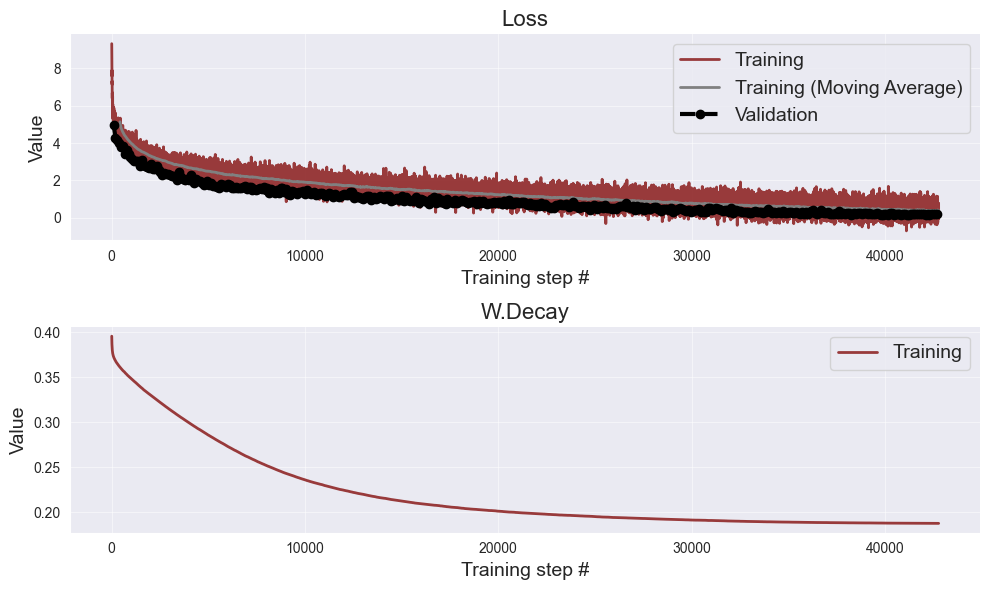

In [11]:
bf.diagnostics.plot_losses(history['train_losses'], history['val_losses'], moving_average=True, fig_size=(10, 6));

In [12]:
# Check if training converged
if np.isnan(history['val_losses'].iloc[-1]).any():
    print('Training failed with NaN loss at the end')
    if np.isnan(history['val_losses'].iloc[-max_to_keep:]).all():
        print('Training failed with NaN loss for all latest checkpoints')

# Find the checkpoint with the lowest validation loss out of the last max_to_keep
recent_losses = history['val_losses'].iloc[-max_to_keep:]
best_valid_epoch = recent_losses['Loss'].idxmin() + 1  # checkpoints are 1-based indexed
new_checkpoint = trainer.manager.latest_checkpoint.rsplit('-', 1)[0] + f'-{best_valid_epoch}'    
trainer.checkpoint.restore(new_checkpoint)
print("Networks loaded from {}".format(new_checkpoint))

Networks loaded from amortizer-cell-migration-attention-7-bid-MMD-manual/ckpt-424


# Diagnostic plots

In [13]:
from tarp import get_tarp_coverage
from matplotlib import pyplot as plt

In [14]:
valid_data_config = trainer.configurator(valid_data)

/Users/jonas.arruda/miniconda/envs/CellMigration/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jonas.arruda/miniconda/envs/CellMigration/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [15]:
posterior_samples = amortizer.sample(valid_data_config, n_samples=100)
posterior_samples = posterior_samples * p_std + p_mean
prior_draws = valid_data_config["parameters"] * p_std + p_mean

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 1.                    Confidence intervals might be unreliable!


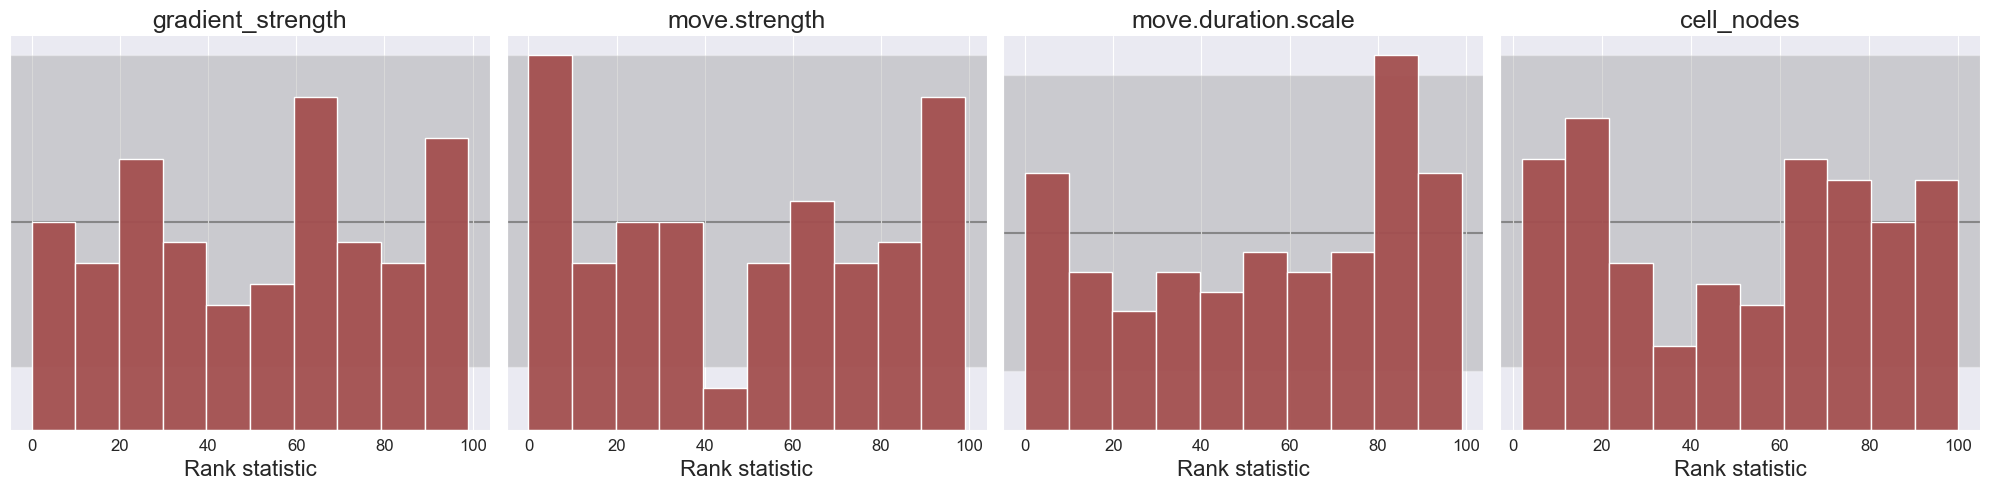

In [16]:
bf.diagnostics.plot_sbc_histograms(posterior_samples, prior_draws, num_bins=10, param_names=param_names);

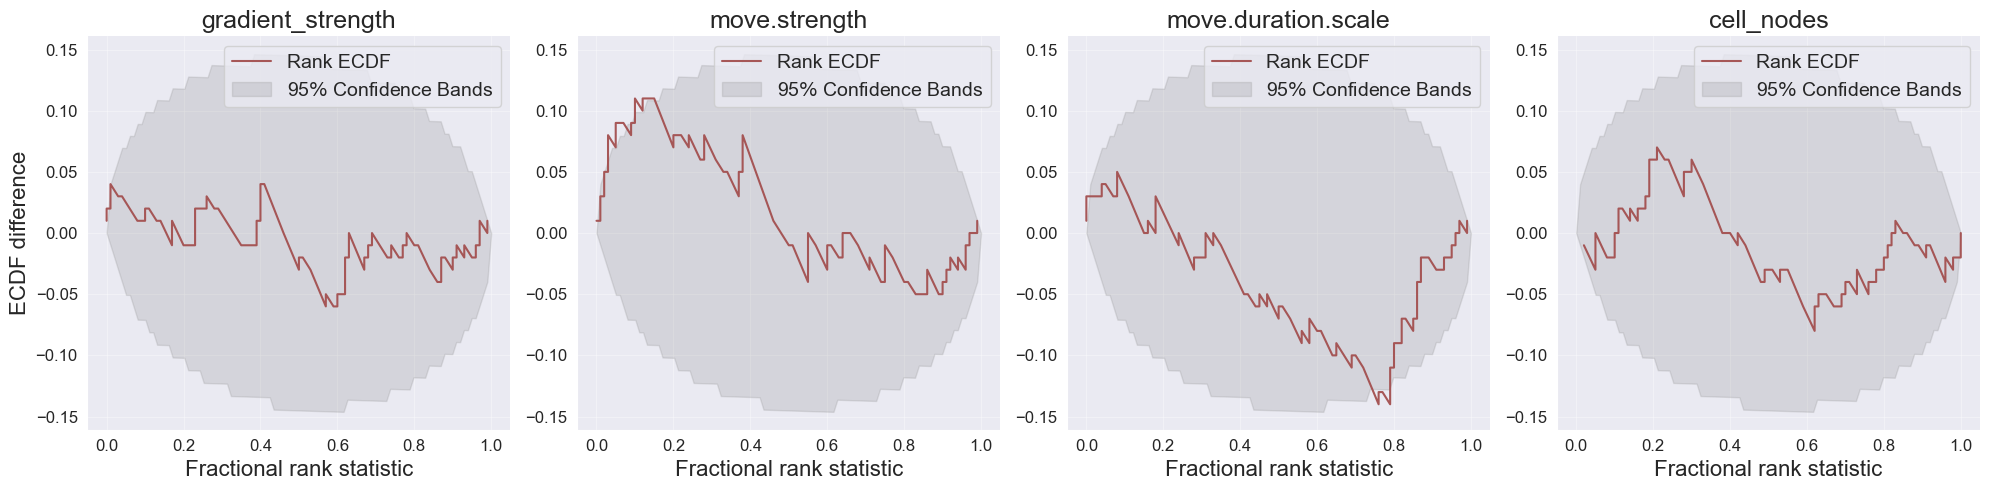

In [17]:
fig = bf.diagnostics.plot_sbc_ecdf(posterior_samples, prior_draws, difference=True, param_names=param_names)
plt.savefig(f'../results/{checkpoint_path}/sbc_ecdf.png')

In [18]:
posterior_samples = amortizer.sample(valid_data_config, n_samples=1000)
posterior_samples = posterior_samples * p_std + p_mean

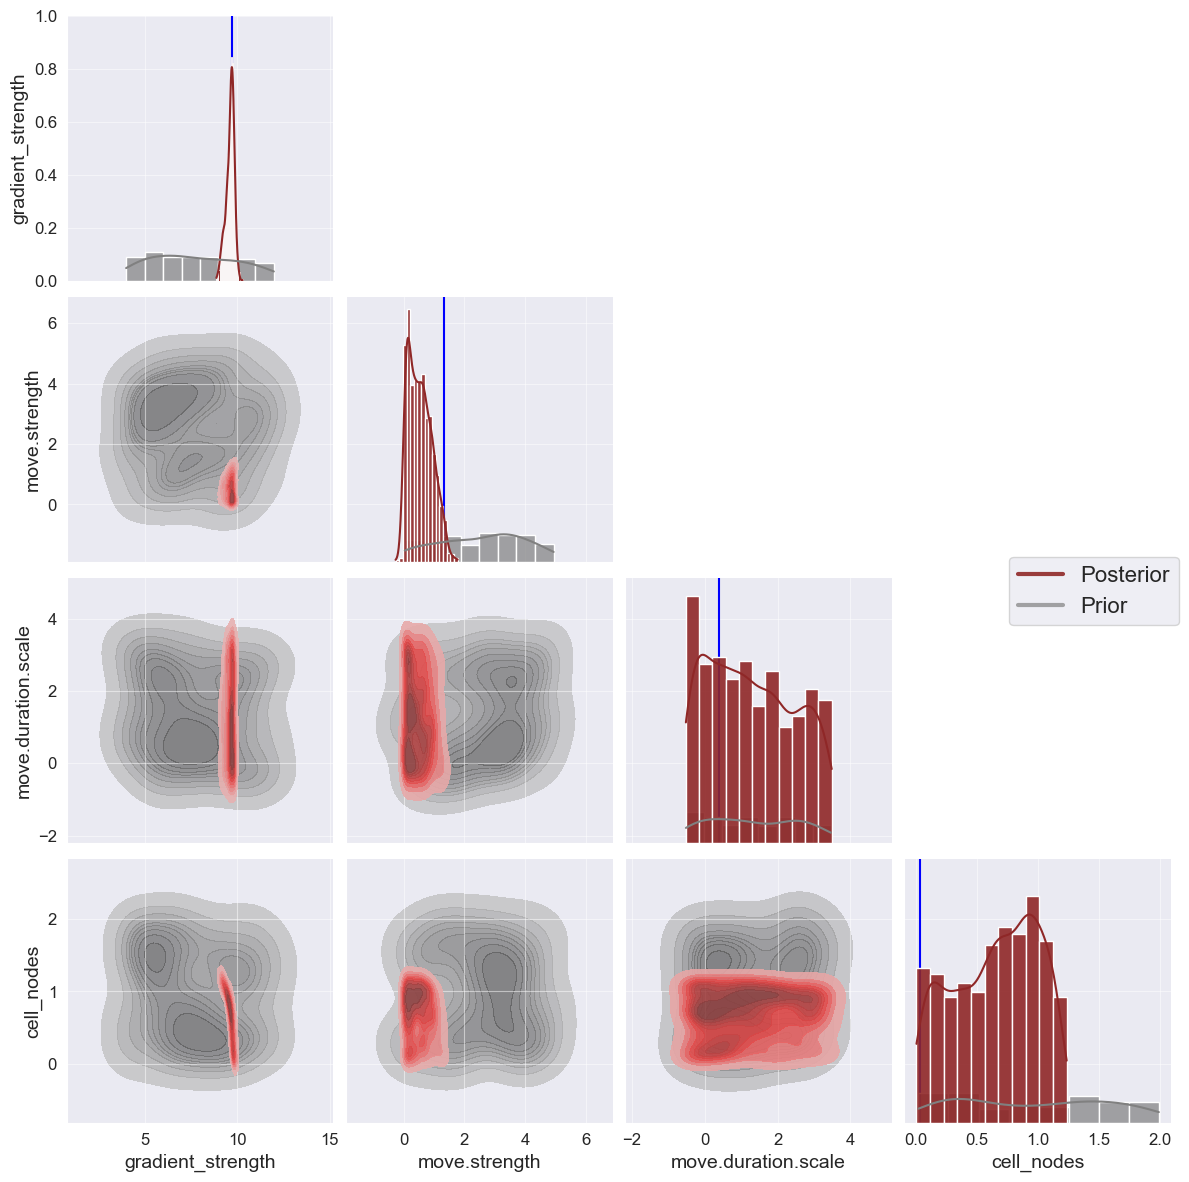

In [19]:
sample_id = 0
fig = bf.diagnostics.plot_posterior_2d(posterior_draws=posterior_samples[sample_id], prior_draws=prior_draws[:posterior_samples.shape[1]],
                                 param_names=param_names)
# from figure get axis
ax = fig.get_axes()
for i, a in enumerate(ax):
    # plot only on the diagonal
    if i == i // len(param_names) * (len(param_names)+1):
        a.axvline(prior_draws[sample_id][i // len(param_names)], color='b', label='True parameter')
plt.show()

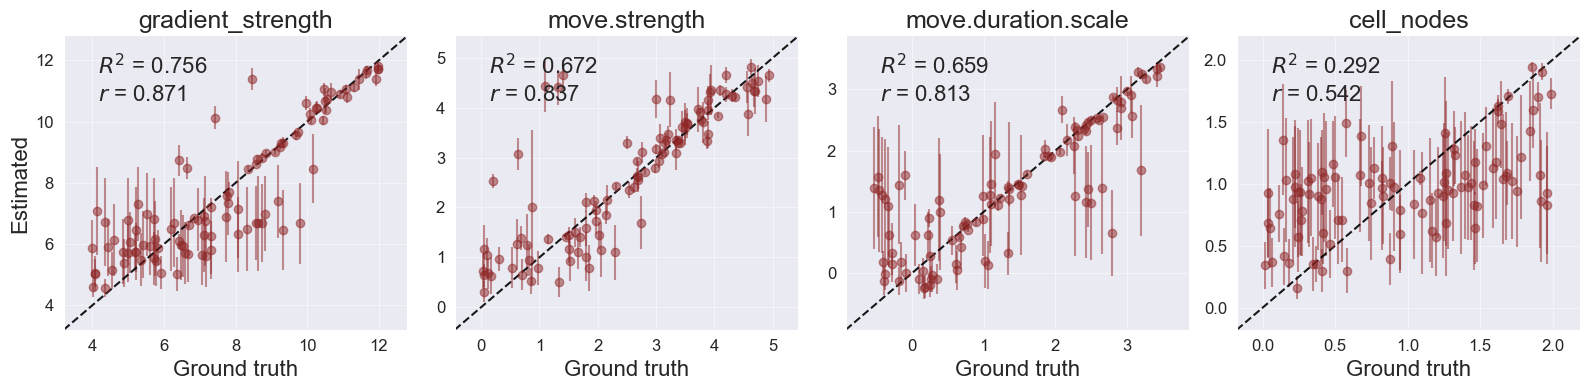

In [20]:
fig = bf.diagnostics.plot_recovery(posterior_samples, prior_draws, param_names=param_names)
plt.savefig(f'../results/{checkpoint_path}/recovery.png')

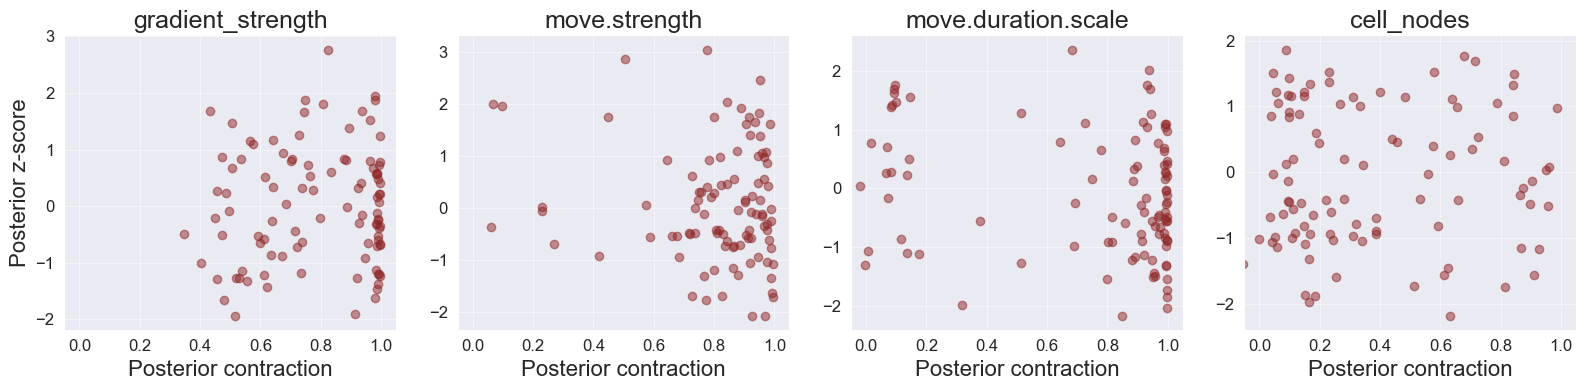

In [21]:
bf.diagnostics.plot_z_score_contraction(posterior_samples, prior_draws, param_names=param_names);

In [22]:
posterior_samples_reshaped = posterior_samples.reshape(posterior_samples.shape[1], posterior_samples.shape[0], posterior_samples.shape[2])

In [23]:
ecp_bootstrap, alpha = get_tarp_coverage(posterior_samples_reshaped, prior_draws, references='random', #posterior_samples_reshaped[0, :, :]
                                         metric='euclidean', norm=True, bootstrap=True)

100%|██████████| 100/100 [00:00<00:00, 287.95it/s]


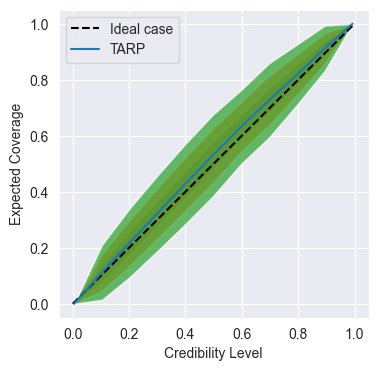

In [24]:
k_sigma = [1, 2, 3]

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot([0, 1], [0, 1], ls='--', color='k', label="Ideal case")
ax.plot(alpha, ecp_bootstrap.mean(axis=0), label='TARP')
for k in k_sigma:
    ax.fill_between(alpha, 
                    ecp_bootstrap.mean(axis=0) - k * ecp_bootstrap.std(axis=0), 
                    ecp_bootstrap.mean(axis=0) + k * ecp_bootstrap.std(axis=0), 
                    alpha = 0.7)
ax.legend()
ax.set_ylabel("Expected Coverage")
ax.set_xlabel("Credibility Level")
plt.show()

# Test on synthetic data

In [25]:
# simulate test data
test_params = np.log10(list(obs_pars.values()))
if not os.path.exists('test_sim.npy'):
    test_sim_full = bayes_simulator(test_params[np.newaxis])
    test_sim = test_sim_full['sim_data']
    np.save('test_sim.npy', test_sim)
else:
    test_sim = np.load('test_sim.npy')
    test_sim_full = {'sim_data': test_sim}
test_sim.shape

(1, 50, 120, 2)

In [26]:
test_posterior_samples = amortizer.sample(trainer.configurator(test_sim_full), n_samples=100)
test_posterior_samples = test_posterior_samples * p_std + p_mean

# compute the log posterior of the test data
input_dict = {
    'sim_data': np.repeat(test_sim, repeats=100, axis=0),
    'parameters': test_posterior_samples
}
log_prob = amortizer.log_posterior(trainer.configurator(input_dict))
    
# get the MAP
map_idx = np.argmax(log_prob)

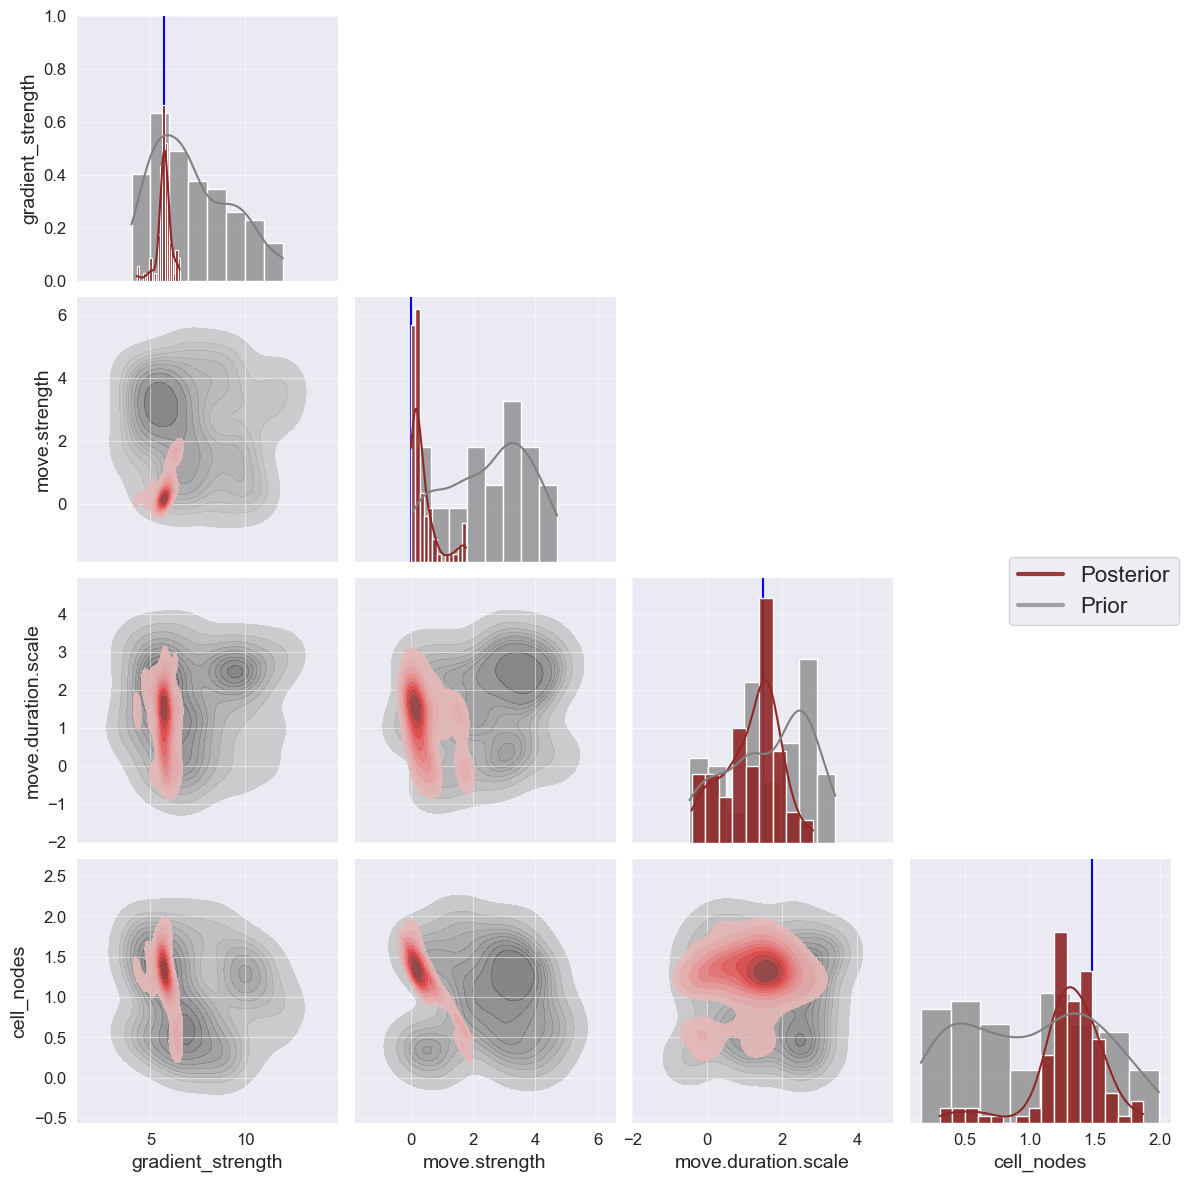

In [27]:
fig = bf.diagnostics.plot_posterior_2d(posterior_draws=test_posterior_samples,
                                       prior_draws=prior_draws[:test_posterior_samples.shape[0]],
                                       param_names=param_names)
# from figure get axis
ax = fig.get_axes()
for i, a in enumerate(ax):
    # plot only on the diagonal
    if i == i // len(param_names) * (len(param_names)+1):
        a.axvline(test_params[i // len(param_names)], color='b', label='True parameter')
plt.savefig(f'../results/{checkpoint_path}/posterior_vs_prior.png')
plt.show()

In [28]:
# get posterior samples and simulate
if not os.path.exists(checkpoint_path+'/posterior_sim.npy'):
    # simulate the data
    posterior_sim = bayes_simulator(test_posterior_samples)['sim_data']
    np.save(checkpoint_path+'/posterior_sim.npy', posterior_sim)
    
    print('map_sim', map_idx, log_prob[map_idx], test_posterior_samples[map_idx])
else:
    posterior_sim = np.load(checkpoint_path+'/posterior_sim.npy')
    map_sim = posterior_sim[map_idx_sim]

In [29]:
# compute the summary statistics
synthetic_summary_stats_list = [reduced_coordinates_to_sumstat(t) for t in test_sim]  # should be only one population
simulation_synth_summary_stats_list = [reduced_coordinates_to_sumstat(pop_sim) for pop_sim in posterior_sim]

# compute the mean of the summary statistics
ad_mean_synth, MSD_mean_synth, TA_mean_synth, VEL_mean_synth, WT_mean_synth, ad_mean_synth_averg, MSD_mean_synth_averg, TA_mean_synth_averg, VEL_mean_synth_averg, WT_mean_synth_averg = compute_mean_summary_stats(synthetic_summary_stats_list)
ad_mean_synth_sim, MSD_mean_synth_sim, TA_mean_synth_sim, VEL_mean_synth_sim, WT_mean_synth_sim, ad_mean_synth_sim_averg, MSD_mean_synth_sim_averg, TA_mean_synth_sim_averg, VEL_mean_synth_sim_averg, WT_mean_synth_sim_averg = compute_mean_summary_stats(simulation_synth_summary_stats_list)

Angle Degree KS Statistic: 0.25788497217068646
Angle Degree P-value: 0.07270670630029825, False: different distributions
MSD KS Statistic: 0.9591836734693877
MSD P-value: 0.12, False: different distributions
Turning Angle KS Statistic: 0.19202226345083487
Turning Angle P-value: 0.3069571578050206, False: different distributions
Velocity KS Statistic: 1.0
Velocity P-value: 2.795672232392543e-27, True: different distributions
Waiting Time KS Statistic: 0.9577777777777777
Waiting Time P-value: 2.2829497017541454e-24, True: different distributions


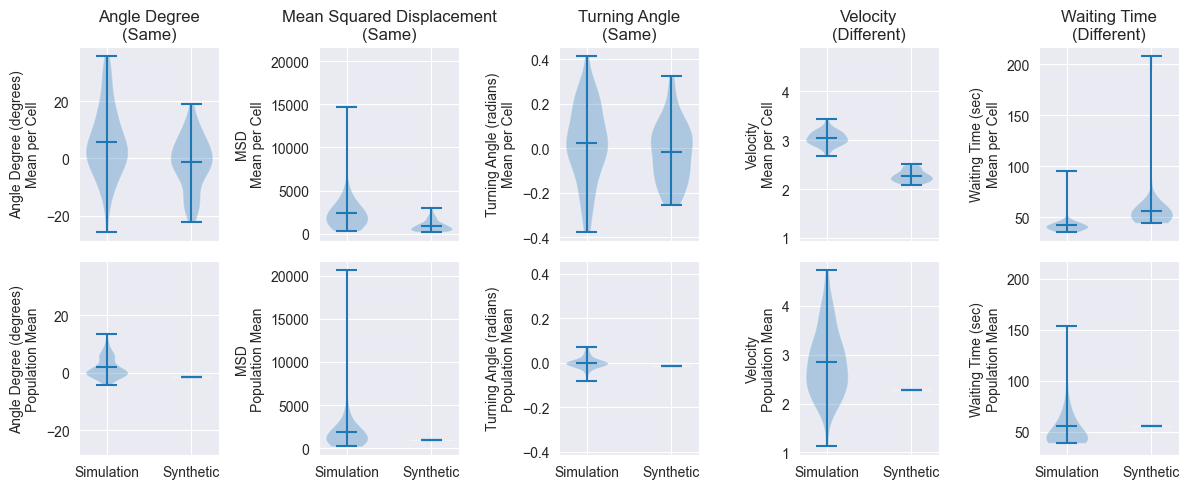

Wasserstein distance: 1517.5607313054068


In [30]:
# plot the summary statistics
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey='col', tight_layout=True, figsize=(12, 5))
# Perform the Kolmogorov-Smirnov test
ks_statistic, p_value = stats.ks_2samp(ad_mean_synth_sim[map_idx_sim], ad_mean_synth[0])
print(f"Angle Degree KS Statistic: {ks_statistic}")
print(f"Angle Degree P-value: {p_value}, {p_value < 0.05}: different distributions")
ax[0, 0].violinplot([ad_mean_synth_sim[map_idx_sim], ad_mean_synth[0]], showmeans=True)
if p_value < 0.05:
    ax[0, 0].set_title(f'Angle Degree\n(Different)')
else:
    ax[0, 0].set_title(f'Angle Degree\n(Same)')
ax[0, 0].set_ylabel(f'Angle Degree (degrees)\nMean per Cell')
ax[1, 0].violinplot([ad_mean_synth_sim_averg, ad_mean_synth_averg], showmeans=True)
ax[1, 0].set_ylabel(f'Angle Degree (degrees)\nPopulation Mean')
ax[1, 0].set_xticks([1, 2], ['Simulation', 'Synthetic'])

ks_statistic, p_value = stats.ks_2samp(MSD_mean_synth_sim_averg[map_idx_sim], MSD_mean_synth[0])
print(f"MSD KS Statistic: {ks_statistic}")
print(f"MSD P-value: {p_value}, {p_value < 0.05}: different distributions")
ax[0, 1].violinplot([MSD_mean_synth_sim[map_idx_sim], MSD_mean_synth[0]], showmeans=True)
if p_value < 0.05:
    ax[0, 1].set_title(f'Mean Squared Displacement\n(Different)')
else:
    ax[0, 1].set_title(f'Mean Squared Displacement\n(Same)')
ax[0, 1].set_ylabel(f'MSD\nMean per Cell')
ax[1, 1].violinplot([MSD_mean_synth_sim_averg, MSD_mean_synth_averg], showmeans=True)
ax[1, 1].set_ylabel(f'MSD\nPopulation Mean')
ax[1, 1].set_xticks([1, 2], ['Simulation', 'Synthetic'])

ks_statistic, p_value = stats.ks_2samp(TA_mean_synth_sim[map_idx_sim], TA_mean_synth[0])
print(f"Turning Angle KS Statistic: {ks_statistic}")
print(f"Turning Angle P-value: {p_value}, {p_value < 0.05}: different distributions")
ax[0, 2].violinplot([TA_mean_synth_sim[map_idx_sim], TA_mean_synth[0]], showmeans=True)
if p_value < 0.05:
    ax[0, 2].set_title(f'Turning Angle\n(Different)')
else:
    ax[0, 2].set_title(f'Turning Angle\n(Same)')
ax[0, 2].set_ylabel(f'Turning Angle (radians)\nMean per Cell')
ax[1, 2].violinplot([TA_mean_synth_sim_averg, TA_mean_synth_averg], showmeans=True)
ax[1, 2].set_ylabel(f'Turning Angle (radians)\nPopulation Mean')
ax[1, 2].set_xticks([1, 2], ['Simulation', 'Synthetic'])

ks_statistic, p_value = stats.ks_2samp(VEL_mean_synth_sim[map_idx_sim], VEL_mean_synth[0])
print(f"Velocity KS Statistic: {ks_statistic}")
print(f"Velocity P-value: {p_value}, {p_value < 0.05}: different distributions")
ax[0, 3].violinplot([VEL_mean_synth_sim[map_idx_sim], VEL_mean_synth[0]], showmeans=True)
if p_value < 0.05:
    ax[0, 3].set_title(f'Velocity\n(Different)')
else:
    ax[0, 3].set_title(f'Velocity\n(Same)')
ax[0, 3].set_ylabel(f'Velocity\nMean per Cell')
ax[1, 3].violinplot([VEL_mean_synth_sim_averg, VEL_mean_synth_averg], showmeans=True)
ax[1, 3].set_ylabel(f'Velocity\nPopulation Mean')
ax[1, 3].set_xticks([1, 2], ['Simulation', 'Synthetic'])

ks_statistic, p_value = stats.ks_2samp(WT_mean_synth_sim[map_idx_sim], WT_mean_synth[0])
print(f"Waiting Time KS Statistic: {ks_statistic}")
print(f"Waiting Time P-value: {p_value}, {p_value < 0.05}: different distributions")
ax[0, 4].violinplot([WT_mean_synth_sim[map_idx_sim], WT_mean_synth[0]], showmeans=True)
if p_value < 0.05:
    ax[0, 4].set_title(f'Waiting Time\n(Different)')
else:
    ax[0, 4].set_title(f'Waiting Time\n(Same)')
ax[0, 4].set_ylabel(f'Waiting Time (sec)\nMean per Cell')
ax[1, 4].violinplot([WT_mean_synth_sim_averg, WT_mean_synth_averg], showmeans=True)
ax[1, 4].set_ylabel(f'Waiting Time (sec)\nPopulation Mean')
ax[1, 4].set_xticks([1, 2], ['Simulation', 'Synthetic'])
plt.savefig(f'../results/{checkpoint_path}/Summary Stats.png')
plt.show()

# Wasserstein distance
wasserstein_distance = stats.wasserstein_distance(ad_mean_synth_sim[map_idx_sim], ad_mean_synth[0])
wasserstein_distance += stats.wasserstein_distance(MSD_mean_synth_sim[map_idx_sim], MSD_mean_synth[0])
wasserstein_distance += stats.wasserstein_distance(TA_mean_synth_sim[map_idx_sim], TA_mean_synth[0])
wasserstein_distance += stats.wasserstein_distance(VEL_mean_synth_sim[map_idx_sim], VEL_mean_synth[0])
wasserstein_distance += stats.wasserstein_distance(WT_mean_synth_sim[map_idx_sim], WT_mean_synth[0])
print(f"Wasserstein distance: {wasserstein_distance}")

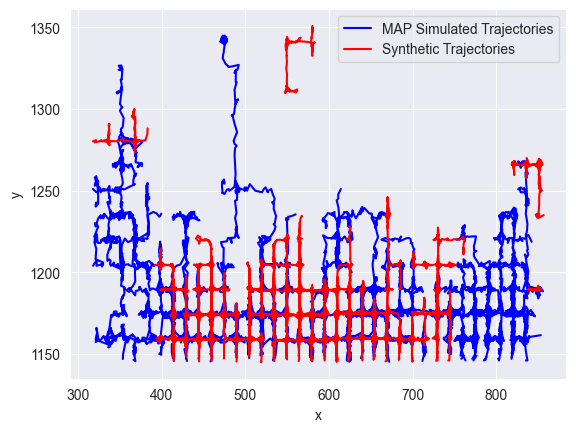

In [31]:
# plot the simulations or the MAP
plt.plot(map_sim[0, :, 0], map_sim[0, :, 1], 'b', label='MAP Simulated Trajectories', alpha=1)
for cell_id in range(1, cells_in_population):           
    plt.plot(map_sim[cell_id, :, 0], map_sim[cell_id, :, 1], 'b')
    
# plot the synthetic data
plt.plot(test_sim[0][0, :, 0], test_sim[0][0, :, 1], 'r', label='Synthetic Trajectories', alpha=1)
for cell_id in range(1, cells_in_population):           
    plt.plot(test_sim[0][cell_id, :, 0], test_sim[0][cell_id, :, 1], 'r')
    
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.savefig(f'../results/{checkpoint_path}/Simulations.png')
plt.show()

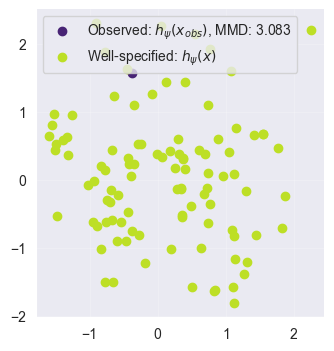

  0%|          | 0/500 [00:00<?, ?it/s]

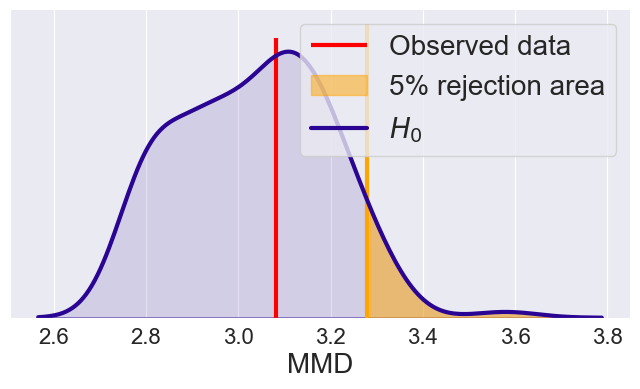

In [32]:
if summary_loss is not None:
    test_data_config = trainer.configurator(test_sim_full)
    summary_statistics = trainer.amortizer.summary_net(valid_data_config["summary_conditions"])
    summary_statistics_obs = trainer.amortizer.summary_net(test_data_config["summary_conditions"])
    mmd = np.sqrt(maximum_mean_discrepancy(summary_statistics, summary_statistics_obs))
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    colors = cm.viridis(np.linspace(0.1, 0.9, 2))
    ax.scatter(
        summary_statistics_obs[:, 0], summary_statistics_obs[:, 1], 
        color=colors[0], label=r"Observed: $h_{\psi}(x_{obs})$" + f", MMD: {mmd:.3f}"
    )
    ax.scatter(summary_statistics[:, 0], summary_statistics[:, 1], 
               color=colors[1], label=r"Well-specified: $h_{\psi}(x)$")
    ax.legend()
    ax.grid(alpha=0.2)
    plt.gca().set_aspect("equal")
    sns.despine(ax=ax)
    fig.savefig(f'../results/{checkpoint_path}/Synthetic Summary Latent Space.png', bbox_inches='tight')
    plt.show()
    
    MMD_sampling_distribution, MMD_observed = trainer.mmd_hypothesis_test(
        observed_data=test_data_config, 
        reference_data=valid_data_config,  # if not provided, will use the generative model
        num_null_samples=500,
        bootstrap=True  # if True, use the reference data as null samples
    )
    fig = bf.diagnostics.plot_mmd_hypothesis_test(MMD_sampling_distribution, MMD_observed)
    fig.savefig(f'../results/{checkpoint_path}/Synthetic MMD.png', bbox_inches='tight')
    plt.show()

# Parameter Identifiability

# Real Data

In [33]:
wasserstein_distance_dict = {0: np.nan, 1: np.nan}

In [48]:
# load real data
real_data_id = [0, 1][0]
# reference_coordinates = [415/1.31, 1500/1.31] 
if real_data_id == 0:
    real_data_df = pd.read_csv('../real_data/37C-1_crop.csv')
    y_size = 739.79
    x_size = 279.74
    x_offset, y_offset = 7.5, 2
    y_lin_shift = 0
else:
    # more important data set, closer to the truth
    real_data_df = pd.read_csv('../real_data/37C_ctrl2.csv')
    y_size = 882.94
    x_size = 287.03
    x_offset, y_offset = 3, 7.5
    y_lin_shift = 0.05
    
# define the window
# simulation coordinates, length of the gap: 1351-1145 = 206
# in real data: 270
# 270/206 = 1.31
# morpheus size of image: 1173x2500
factor = 1.31
# reconstruction of the window assuming that it is centered
window_x1, window_x2 = (1173-y_size/factor)/2., 1173-(1173-y_size/factor)/2.
window_y1, window_y2 = (2500-x_size/factor)/2., 2500-(2500-x_size/factor)/2.

# remove first three rows
real_data_df = real_data_df.iloc[3:]
# only keep positions and time
real_data_df = real_data_df[['TRACK_ID', 'POSITION_X', 'POSITION_Y', 'POSITION_T']]
# convert to numeric
real_data_df = real_data_df.apply(pd.to_numeric, errors='coerce')

# scale to morpheus coordinates
real_data_df['x'] = real_data_df['POSITION_X'] / factor + window_x1 + x_offset
real_data_df['y'] = real_data_df['POSITION_Y'] / factor + window_y1 + y_offset
# data is tilted
real_data_df['x'] = real_data_df['x'] + (window_y2-real_data_df['y']) * y_lin_shift
# time
real_data_df['t'] = real_data_df['POSITION_T']

In [49]:
real_data = []
cut_region_real_data = True
sequence_lengths_real = []
# each cell is of different length, each with x and y coordinates, make a tensor out of it
for s_id, sample in enumerate(real_data_df.TRACK_ID.unique()):
    cell = real_data_df[real_data_df.TRACK_ID == sample]
    # order by time
    cell = cell.sort_values('POSITION_T', ascending=True)
    sequence_lengths_real.append(len(cell['y']))
    if cut_region_real_data:
        cell = cut_region(cell, x_min=316.5, x_max=856.5, y_min=1145, y_max=1351, return_longest=True)
        if cell is None:
            continue
        cell = cell[0]
    # pre-pad the data with zeros, but first write zeros as nans to compute the mean and std
    track = np.ones((max_sequence_length+1, 2)) * np.nan
    track[-len(cell['x'][:max_sequence_length]):, 0] = cell['x'][:max_sequence_length]
    track[-len(cell['y'][:max_sequence_length]):, 1] = cell['y'][:max_sequence_length]
    #track[cell['t'], 0] = cell['x']
    #track[cell['t'], 1] = cell['y']
    real_data.append(track[1:])  # remove the first time point, same as in the simulation (often nan anyway)
  
real_data = np.stack(real_data)  
# order real_data by number of nans, to get data_dim cells with the longest trajectories
real_data_full = real_data.copy()
real_data = real_data[:cells_in_population]
print(real_data.shape)

(50, 120, 2)


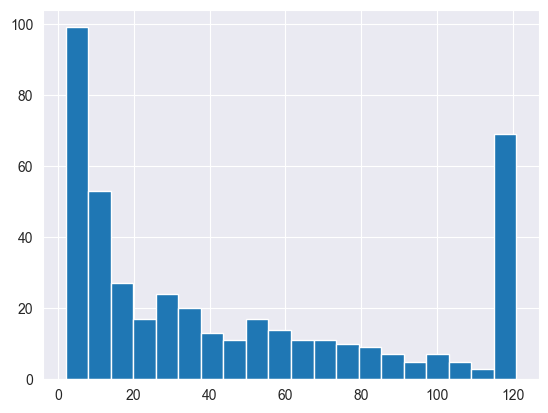

121

In [50]:
plt.hist(sequence_lengths_real, bins=20)
plt.show()

max(sequence_lengths_real)

Zelldichte macht was aus

Wo wollen Zellen hin? welche parameter beeinflussen das ganze? Zelldichte?

1,5mm

1 (nicht so gut, extrema)
739.79x279.74  microns
20231x768 pixel


2 (wesentlich mehr der Wahrheit)
882.94x287.03 microns
2424x788 pixel


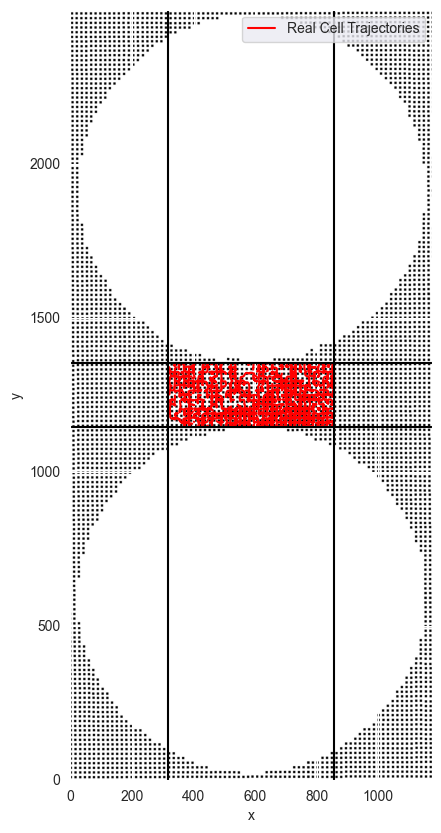

In [51]:
fig = plt.figure(figsize=(10, 10))
plt.plot(real_data_full[0, :, 0], real_data_full[0, :, 1], 'r', label='Real Cell Trajectories')
for cell_id in range(1, real_data_full.shape[0]):           
    plt.plot(real_data_full[cell_id, :, 0], real_data_full[cell_id, :, 1], 'r')
plt.xlabel('x')
plt.ylabel('y')
plt.axline((415/1.31, 1145), (856.5, 1145), color='black')  # lower horizontal line
plt.axline((415/1.31, 1351), (856.5, 1351), color='black')  # upper horizontal line
plt.axline((415/1.31, 1145), (415/1.31, 1351), color='black')  # left vertical line
plt.axline((856.5, 1145), (856.5, 1351), color='black')  # right vertical line
#plt.axline((window_x1, window_y1), (window_x2, window_y1), color='black')  # lower horizontal line
#plt.axline((window_x1, window_y2), (window_x2, window_y2), color='black')  # upper horizontal line
#plt.axline((window_x1, window_y1), (window_x1, window_y2), color='black')  # left vertical line
#plt.axline((window_x2, window_y1), (window_x2, window_y2), color='black')  # right vertical line
tiff_im = plt.imread('Cell_migration_grid_v3_final2_invers.tiff')
plt.imshow(tiff_im, origin='lower')
plt.legend()
plt.show()

In [52]:
# batch the real data
batches = [real_data_full[i * cells_in_population:(i + 1) * cells_in_population] 
           for i in range(len(real_data_full) // cells_in_population)]
real_posterior_samples_full = []
map_idx_full = []
n_samples = 100

for b in batches:
    real_posterior_samples = amortizer.sample(trainer.configurator({'sim_data': b[np.newaxis]}), 
                                          n_samples=n_samples)
    real_posterior_samples = real_posterior_samples * p_std + p_mean
    real_posterior_samples_full.append(real_posterior_samples)
    
    # compute the log posterior of the test data
    input_dict = {
        'sim_data': np.repeat(b[np.newaxis], repeats=n_samples, axis=0),
        'parameters': real_posterior_samples
    }
    log_prob = amortizer.log_posterior(trainer.configurator(input_dict))
    # get the MAP
    map_idx = np.argmax(log_prob)
    map_idx_full.append(map_idx)
     
real_posterior_samples = np.concatenate(real_posterior_samples_full)
map_idxs = np.array(map_idx_full)

/Users/jonas.arruda/miniconda/envs/CellMigration/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jonas.arruda/miniconda/envs/CellMigration/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


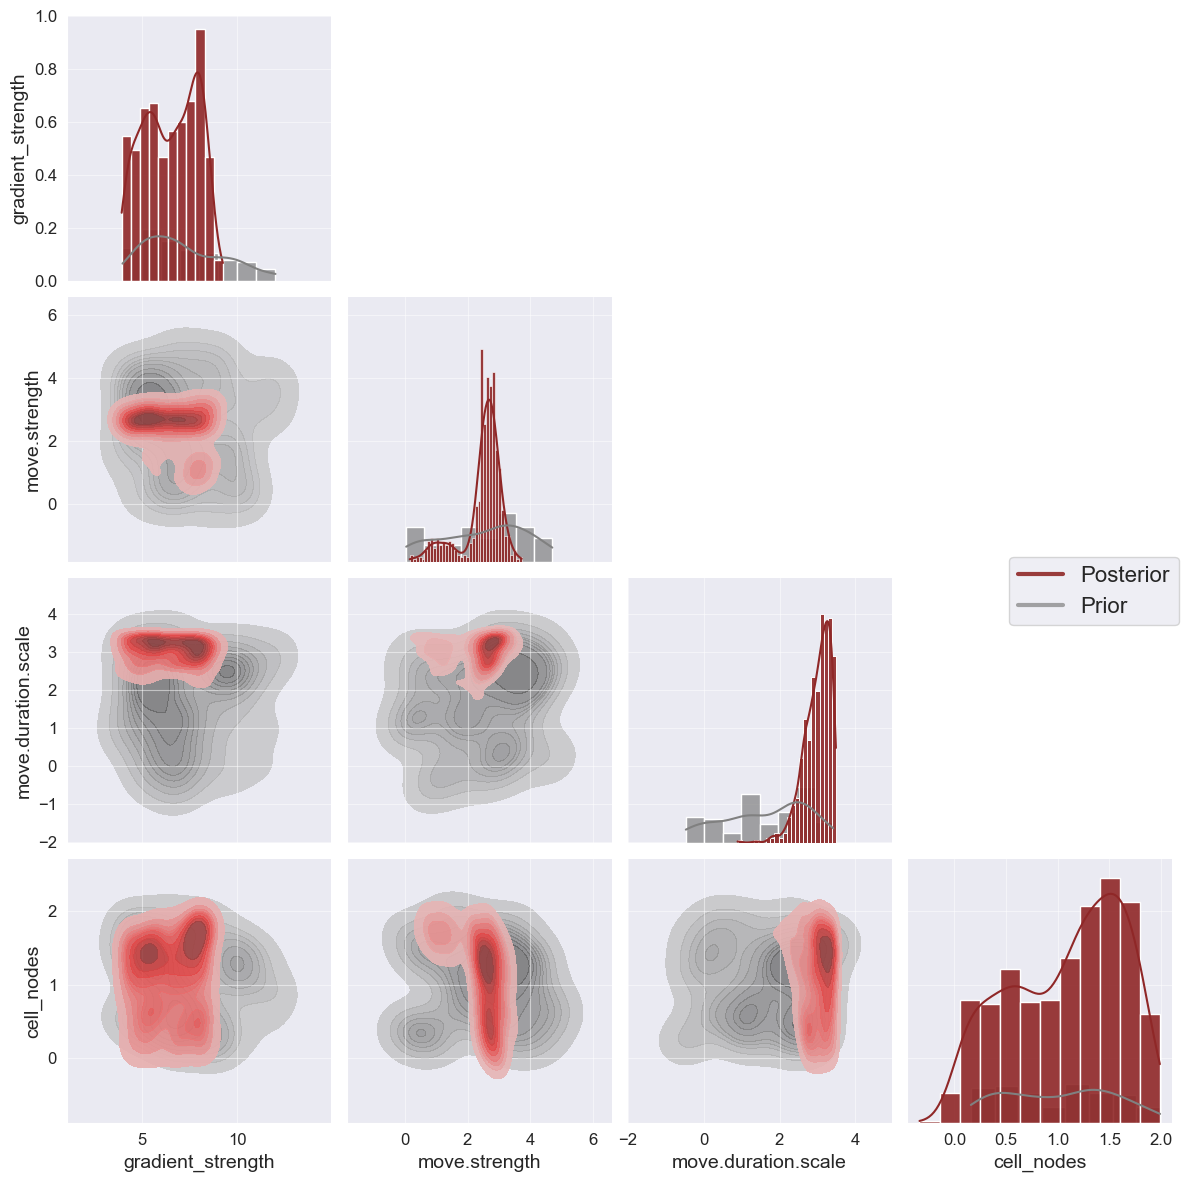

In [53]:
fig = bf.diagnostics.plot_posterior_2d(posterior_draws=real_posterior_samples,
                                       prior_draws=prior_draws[:real_posterior_samples.shape[0]],
                                       param_names=param_names)
plt.savefig(f'../results/{checkpoint_path}/Real_{real_data_id} posterior_vs_prior.png')
plt.show()

In [54]:
# get posterior samples and simulate
if not os.path.exists(checkpoint_path+f'/posterior_sim_real_{real_data_id}.npy'):
    # simulate the data
    map_sims_real = []
    for i, map_idx in enumerate(map_idxs):
        map_sim_real = bayes_simulator(real_posterior_samples[map_idx + i*n_samples][np.newaxis])['sim_data'][0]
        np.save(checkpoint_path+f'/posterior_sim_real_{real_data_id}_{i}.npy', map_sim_real)
        map_sims_real.append(map_sim_real)
else:
    map_sims_real = []
    for i, map_idx in enumerate(map_idxs):
        map_sim_real = np.load(checkpoint_path+f'/posterior_sim_real_{real_data_id}_{i}.npy')
        map_sims_real.append(map_sim_real)
        
map_sim_real = np.concatenate(map_sims_real)

In [55]:
# compute the summary statistics
real_summary_stats_list = [reduced_coordinates_to_sumstat(real_data_full)]  # should be only one population
simulation_summary_stats_list = [reduced_coordinates_to_sumstat(map_sim_real)]

# compute the mean of the summary statistics
ad_mean_real, MSD_mean_real, TA_mean_real, VEL_mean_real, WT_mean_real, _, _, _, _, _ = compute_mean_summary_stats(real_summary_stats_list)
ad_mean_real_sim, MSD_mean_real_sim, TA_mean_real_sim, VEL_mean_real_sim, WT_mean_real_sim, _, _, _, _, _ = compute_mean_summary_stats(simulation_summary_stats_list)

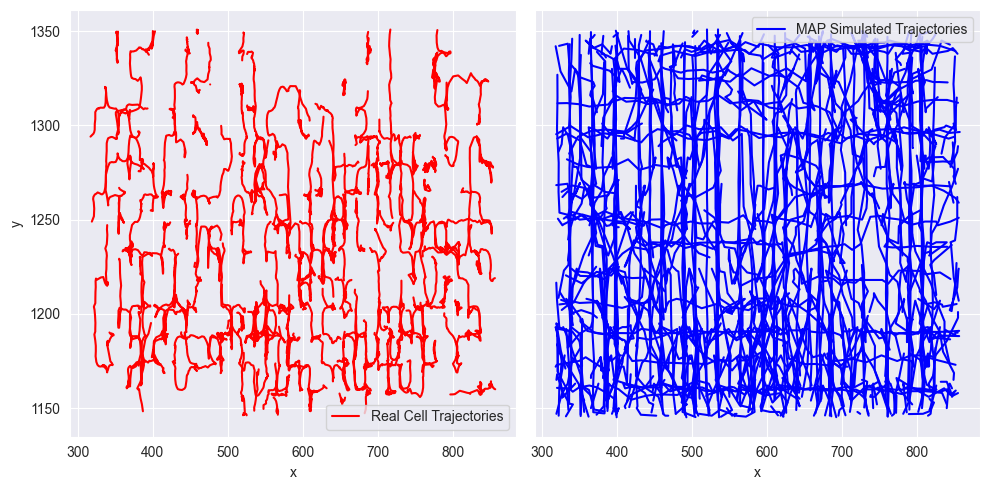

In [56]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, tight_layout=True, figsize=(10, 5))
tiff_im = plt.imread('Cell_migration_grid_v3_final2_invers.tiff')

# plot the simulations or the MAP
#ax[1].imshow(tiff_im)
ax[1].plot(map_sim_real[0, :, 0], map_sim_real[0, :, 1], 'b', label='MAP Simulated Trajectories')
for cell_id in range(1, map_sim_real.shape[0]):           
    ax[1].plot(map_sim_real[cell_id, :, 0], map_sim_real[cell_id, :, 1], 'b')

# plot the synthetic data
#ax[0].imshow(tiff_im)
ax[0].plot(real_data_full[0, :, 0], real_data_full[0, :, 1], 'r', label='Real Cell Trajectories')
for cell_id in range(1, real_data_full.shape[1]): #cells_in_population):           
    ax[0].plot(real_data_full[cell_id, :, 0], real_data_full[cell_id, :, 1], 'r')
#ax[0].plot(real_data_full[cells_in_population, :, 0], real_data_full[cells_in_population, :, 1], 'r', 
#           label='(not used for inference)', alpha=0.5)
#for cell_id in range(cells_in_population+1, real_data_full.shape[1]):           
#    ax[0].plot(real_data_full[cell_id, :, 0], real_data_full[cell_id, :, 1], 'r', alpha=0.5)
    
ax[0].set_ylabel('y')
for a in ax:
    a.legend()
    a.set_xlabel('x')
plt.savefig(f'../results/{checkpoint_path}/Real_{real_data_id} vs Simulations.png')
plt.show()

In [57]:
# Wasserstein distance
wasserstein_distance = stats.wasserstein_distance(ad_mean_real_sim[0], ad_mean_real[0])
wasserstein_distance += stats.wasserstein_distance(MSD_mean_real_sim[0], MSD_mean_real[0])
wasserstein_distance += stats.wasserstein_distance(TA_mean_real_sim[0], TA_mean_real[0])
wasserstein_distance += stats.wasserstein_distance(VEL_mean_real_sim[0], VEL_mean_real[0])
print(f"Wasserstein distance: {wasserstein_distance}")
wasserstein_distance += stats.wasserstein_distance(WT_mean_real_sim[0], WT_mean_real[0])
print(f"Wasserstein distance (with waiting time): {wasserstein_distance}")

wasserstein_distance_dict[real_data_id] = wasserstein_distance
print(f"Wasserstein distance both datasets: {np.sum(list(wasserstein_distance_dict.values()))}")

Wasserstein distance: 3005.8075233592513
Wasserstein distance (with waiting time): 3261.474474172402
Wasserstein distance both datasets: 6168.635098064775


Angle Degree KS Statistic: 0.31702925731432857
Angle Degree P-value: 8.513536417739767e-05, True: different distributions
MSD KS Statistic: 0.33735933983495875
MSD P-value: 2.1979991234224964e-05, True: different distributions
Turning Angle KS Statistic: 0.3514628657164291
Turning Angle P-value: 8.284121216728228e-06, True: different distributions
Velocity KS Statistic: 0.3215303825956489
Velocity P-value: 6.312038977060935e-05, True: different distributions
Waiting Time KS Statistic: 0.15351462161628138
Waiting Time P-value: 0.0023160899281430966, True: different distributions


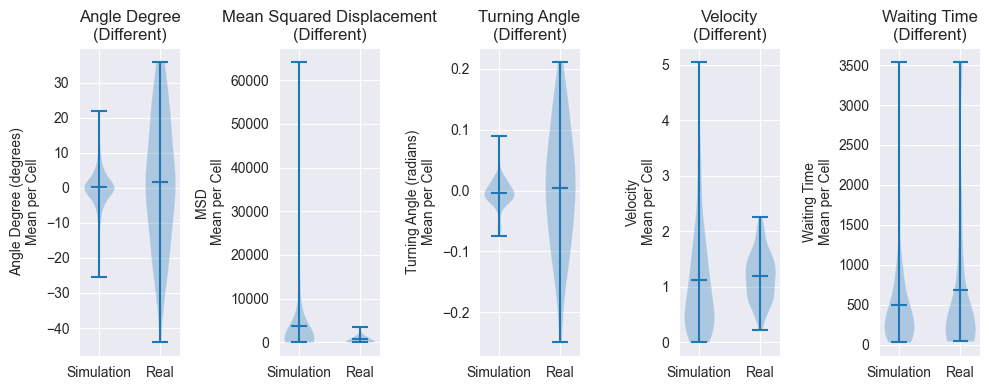

In [58]:
# plot the summary statistics
fig, ax = plt.subplots(nrows=1, ncols=5, sharex=True, sharey='col', tight_layout=True, figsize=(10, 4))
# Perform the Kolmogorov-Smirnov test
ks_statistic, p_value = stats.ks_2samp(ad_mean_real_sim[0], ad_mean_real[0])
print(f"Angle Degree KS Statistic: {ks_statistic}")
print(f"Angle Degree P-value: {p_value}, {p_value < 0.05}: different distributions")
ax[0].violinplot([ad_mean_real_sim[0], ad_mean_real[0]], showmeans=True)
if p_value < 0.05:
    ax[0].set_title(f'Angle Degree\n(Different)')
else:
    ax[0].set_title(f'Angle Degree\n(Same)')
ax[0].set_ylabel(f'Angle Degree (degrees)\nMean per Cell')
ax[0].set_xticks([1, 2], ['Simulation', 'Real'])

ks_statistic, p_value = stats.ks_2samp(MSD_mean_real_sim[0], MSD_mean_real[0])
print(f"MSD KS Statistic: {ks_statistic}")
print(f"MSD P-value: {p_value}, {p_value < 0.05}: different distributions")
ax[1].violinplot([MSD_mean_real_sim[0], MSD_mean_real[0]], showmeans=True)
if p_value < 0.05:
    ax[1].set_title(f'Mean Squared Displacement\n(Different)')
else:
    ax[1].set_title(f'Mean Squared Displacement\n(Same)')
ax[1].set_ylabel(f'MSD\nMean per Cell')
ax[1].set_xticks([1, 2], ['Simulation', 'Real'])

ks_statistic, p_value = stats.ks_2samp(TA_mean_real_sim[0], TA_mean_real[0])
print(f"Turning Angle KS Statistic: {ks_statistic}")
print(f"Turning Angle P-value: {p_value}, {p_value < 0.05}: different distributions")
ax[2].violinplot([TA_mean_real_sim[0], TA_mean_real[0]], showmeans=True)
if p_value < 0.05:
    ax[2].set_title(f'Turning Angle\n(Different)')
else:
    ax[2].set_title(f'Turning Angle\n(Same)')
ax[2].set_ylabel(f'Turning Angle (radians)\nMean per Cell')
ax[2].set_xticks([1, 2], ['Simulation', 'Real'])

ks_statistic, p_value = stats.ks_2samp(VEL_mean_real_sim[0], VEL_mean_real[0])
print(f"Velocity KS Statistic: {ks_statistic}")
print(f"Velocity P-value: {p_value}, {p_value < 0.05}: different distributions")
ax[3].violinplot([VEL_mean_real_sim[0], VEL_mean_real[0]], showmeans=True)
if p_value < 0.05:
    ax[3].set_title(f'Velocity\n(Different)')
else:
    ax[3].set_title(f'Velocity\n(Same)')
ax[3].set_ylabel(f'Velocity\nMean per Cell')
ax[3].set_xticks([1, 2], ['Simulation', 'Real'])

ks_statistic, p_value = stats.ks_2samp(WT_mean_real_sim[0], WT_mean_real[0])
print(f"Waiting Time KS Statistic: {ks_statistic}")
print(f"Waiting Time P-value: {p_value}, {p_value < 0.05}: different distributions")
ax[4].violinplot([WT_mean_real_sim[0], WT_mean_real[0]], showmeans=True)
if p_value < 0.05:
    ax[4].set_title(f'Waiting Time\n(Different)')
else:
    ax[4].set_title(f'Waiting Time\n(Same)')
ax[4].set_ylabel(f'Waiting Time\nMean per Cell')
ax[4].set_xticks([1, 2], ['Simulation', 'Real'])
plt.savefig(f'../results/{checkpoint_path}/Real_{real_data_id} Summary Stats.png')
plt.show()

In [ ]:
if summary_loss is not None:
    real_data_config = trainer.configurator({'sim_data': real_data[np.newaxis]})
    summary_statistics = trainer.amortizer.summary_net(valid_data_config["summary_conditions"])
    summary_statistics_obs = trainer.amortizer.summary_net(real_data_config["summary_conditions"])
    mmd = np.sqrt(maximum_mean_discrepancy(summary_statistics, summary_statistics_obs))
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    colors = cm.viridis(np.linspace(0.1, 0.9, 2))
    ax.scatter(
        summary_statistics_obs[:, 0], summary_statistics_obs[:, 1], 
        color=colors[0], label=r"Observed: $h_{\psi}(x_{obs})$" + f", MMD: {mmd:.3f}"
    )
    ax.scatter(summary_statistics[:, 0], summary_statistics[:, 1], 
               color=colors[1], label=r"Well-specified: $h_{\psi}(x)$")
    ax.legend()
    ax.grid(alpha=0.2)
    plt.gca().set_aspect("equal")
    sns.despine(ax=ax)
    fig.savefig(f'../results/{checkpoint_path}/Real_{real_data_id} Summary Latent Space.png', bbox_inches='tight')
    plt.show()
    
    MMD_sampling_distribution, MMD_observed = trainer.mmd_hypothesis_test(
        observed_data=real_data_config, 
        reference_data=valid_data_config,  # if not provided, will use the generative model
        num_null_samples=500,
        bootstrap=True  # if True, use the reference data as null samples
    )
    fig = bf.diagnostics.plot_mmd_hypothesis_test(MMD_sampling_distribution, MMD_observed)
    fig.savefig(f'../results/{checkpoint_path}/Real_{real_data_id} MMD.png', bbox_inches='tight')
    plt.show()